In [127]:
import pandas as pd 
import numpy as np
import sklearn as skl
import datasets
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

## Create Train / Validate / Test Set

### Submissions

In [66]:
#OLD (BERT BASE CASED): 1 is anti vaccine, 2 is pro vaccine, 0 is noise
# NEW (ROBERTA): 0 is anti vaccine, 1 is noise, 2 is pro vaccine
train_anti_label = {
    'CovidIsACult' : 0, 
    'covidskepticscanada': 0, 
    'FUCKCHINAVIRUS' : 0, 
    'ParentingWithoutFear': 0, 
    'TrueAntiVaccination': 0, 
    'vaccinesideeffects' : 0, 
    'vacci_nation' : 0, 
    'NoNewNormal': 0,
}
train_pro_label = {
    'CoronaVaccines' : 2, 
    'CovidVaccinated' : 2, 
    'VACCINES': 2, 

}

noise_label = {
    'aww': 1, 
    'KidsAreFuckingStupid': 1, 
    'natureismetal': 1, 
}


In [67]:
df = pd.DataFrame()
for key in train_anti_label:
    temp = pd.read_pickle(os.path.join('../../../Files/Submissions/train/'+key+'.pickle'))
    print(key, len(temp))
    df = pd.concat([df, temp])

df['label'] = df.subreddit.map(train_anti_label)

CovidIsACult 115
covidskepticscanada 3062
FUCKCHINAVIRUS 171
ParentingWithoutFear 216
TrueAntiVaccination 4394
vaccinesideeffects 467
vacci_nation 1899
NoNewNormal 109292


In [68]:
df2 = pd.DataFrame()
for key in train_pro_label:
    temp = pd.read_pickle(os.path.join('../../../Files/Submissions/train/'+key+'.pickle'))
    print(key, len(temp))
    df2 = pd.concat([df2, temp])

df2['label'] = df2.subreddit.map(train_pro_label)

CoronaVaccines 307
CovidVaccinated 26721
VACCINES 4236


In [69]:
df3 = pd.DataFrame()
for key in noise_label:
    temp = pd.read_pickle(os.path.join('../../../Files/Submissions/train/'+key+'.pickle'))
    print(key, len(temp))
    df3 = pd.concat([df3, temp])

df3['label'] = df3.subreddit.map(noise_label)

aww 1251041
KidsAreFuckingStupid 52807
natureismetal 37221


In [70]:
print(len(df), len(df2), len(df3))

119616 31264 1341069


In [71]:

anti_train = df.sample(n=23000, random_state=42)
pro_train = df2.sample(n=23000, random_state=42)
noise_train = df3.sample(n=23000 , random_state = 42)

In [72]:
anti_temp = pd.concat([df, anti_train, anti_train]).drop_duplicates(keep=False)
pro_temp = pd.concat([df2, pro_train, pro_train]).drop_duplicates(keep=False)
noise_temp = pd.concat([df3, noise_train, noise_train]).drop_duplicates(keep=False)

In [73]:
train = pd.concat([anti_train, pro_train, noise_train]).sample(frac=1).reset_index(drop=True) #merge and shuffle

In [74]:
anti_val = anti_temp.sample(n=6000, random_state=42)
pro_val = pro_temp.sample(n=3200, random_state=42)
noise_val = noise_temp.sample(n=6000, random_state=42)

In [75]:
valid = pd.concat([anti_val, pro_val, noise_val]).sample(frac=1).reset_index(drop=True)

In [76]:
anti_test = pd.concat([anti_temp, anti_val, anti_val]).drop_duplicates(keep=False)
pro_test = pd.concat([pro_temp, pro_val, pro_val]).drop_duplicates(keep=False)
noise_test = pd.concat([noise_temp, noise_val, noise_val]).drop_duplicates(keep=False)

In [77]:
test = pd.concat([anti_test, pro_test, noise_test]).sample(frac=1).reset_index(drop=True)

In [78]:
print(len(train), len(valid), len(test))

69000 15200 1407749


In [80]:
train['text'] = train['title'] + ' ' + train['selftext']
valid['text'] = valid['title'] + ' ' + valid['selftext']
test['text'] = test['title'] + ' ' + test['selftext']

In [15]:
train.drop('selftext', inplace=True, axis=1)
valid.drop('selftext', inplace=True, axis=1)
test.drop('selftext', inplace=True, axis=1)


In [16]:
train.groupby(by='label').count()

,author,created_utc,id,num_comments,permalink,score,subreddit,title,url
label,,,,,,,,,
0,23000,23000,23000,23000,23000,23000,23000,23000,23000
1,23000,23000,23000,23000,23000,23000,23000,23000,23000
2,23000,23000,23000,23000,23000,23000,23000,23000,23000


In [17]:
valid.groupby(by='label').count()

,author,created_utc,id,num_comments,permalink,score,subreddit,title,url
label,,,,,,,,,
0,6000,6000,6000,6000,6000,6000,6000,6000,6000
1,6000,6000,6000,6000,6000,6000,6000,6000,6000
2,3200,3200,3200,3200,3200,3200,3200,3200,3200


In [18]:
test.groupby(by='label').count()

,author,created_utc,id,num_comments,permalink,score,subreddit,title,url
label,,,,,,,,,
0,1312069,1312069,1312069,1312069,1312069,1312069,1312069,1312069,1312069
1,90616,90616,90616,90616,90616,90616,90616,90616,90616
2,5789,5789,5789,5789,5789,5789,5789,5789,5789


In [81]:
train['subreddit'].value_counts()

aww                     21529
NoNewNormal             20957
CovidVaccinated         19707
VACCINES                 3073
TrueAntiVaccination       872
KidsAreFuckingStupid      872
covidskepticscanada       630
natureismetal             599
vacci_nation              366
CoronaVaccines            220
vaccinesideeffects         85
FUCKCHINAVIRUS             38
ParentingWithoutFear       36
CovidIsACult               16
Name: subreddit, dtype: int64

## Comments

In [93]:
#OLD (BERT BASE CASED): 1 is anti vaccine, 2 is pro vaccine, 0 is noise
# NEW (ROBERTA): 0 is anti vaccine, 1 is noise, 2 is pro vaccine
train_anti_label = {
    'CovidIsACult' : 0, 
    'covidskepticscanada': 0, 
    'FUCKCHINAVIRUS' : 0, 
    'ParentingWithoutFear': 0, 
    'TrueAntiVaccination': 0, 
    'vaccinesideeffects' : 0, 
    'vacci_nation' : 0, 
}
train_pro_label = {
    'CoronaVaccines' : 2, 
    'VACCINES': 2, 

}

noise_label = {
    'aww': 1, 
    'KidsAreFuckingStupid': 1, 
    'natureismetal': 1, 
}

### Merge Files for which 24 months were not be able to be downloaded (for valid reasons)

In [39]:
import datetime
start = int(datetime.datetime(2020, 3, 1).timestamp())
end = int(datetime.datetime(2022, 3, 31).timestamp())
split = 24
step = (end - start) / split
i = start
while i <= end:
    print(i, datetime.datetime.fromtimestamp(i))
    i += step

1583017200 2020-03-01 00:00:00
1585753050.0 2020-04-01 16:57:30
1588488900.0 2020-05-03 08:55:00
1591224750.0 2020-06-04 00:52:30
1593960600.0 2020-07-05 16:50:00
1596696450.0 2020-08-06 08:47:30
1599432300.0 2020-09-07 00:45:00
1602168150.0 2020-10-08 16:42:30
1604904000.0 2020-11-09 07:40:00
1607639850.0 2020-12-10 23:37:30
1610375700.0 2021-01-11 15:35:00
1613111550.0 2021-02-12 07:32:30
1615847400.0 2021-03-15 23:30:00
1618583250.0 2021-04-16 16:27:30
1621319100.0 2021-05-18 08:25:00
1624054950.0 2021-06-19 00:22:30
1626790800.0 2021-07-20 16:20:00
1629526650.0 2021-08-21 08:17:30
1632262500.0 2021-09-22 00:15:00
1634998350.0 2021-10-23 16:12:30
1637734200.0 2021-11-24 07:10:00
1640470050.0 2021-12-25 23:07:30
1643205900.0 2022-01-26 15:05:00
1645941750.0 2022-02-27 07:02:30
1648677600.0 2022-03-31 00:00:00


In [79]:
files = []
for key, value in train_pro_label.items():
    files.append(key)

In [80]:
for file in files:

    merge_data = os.listdir('../../../Files/Comments/temp')
    merged_data = [k for k in merge_data if k.startswith(file)]

    if len(merged_data) > 0:
        df = pd.concat([pd.read_pickle(os.path.join('../../../Files/Comments/temp',candidate)) for candidate in merged_data])
        df.to_pickle(f'../../../Files/Comments/train/{file}.pickle')
        print(f'{file} merged')
        for i in merged_data:
            os.remove(os.path.join('../../../Files/Comments/temp',i))

CoronaVaccines merged
CovidVaccinated merged
VACCINES merged


In [62]:
file

'covidskepticscanada'

In [74]:
merged_data.sort()

In [81]:
merged_data

['VACCINES-1640470050.pickle',
 'VACCINES-1624054950.pickle',
 'VACCINES-1618583250.pickle']

### Generate Training Data

In [94]:
df = pd.DataFrame()
for key in train_anti_label:
    temp = pd.read_pickle(os.path.join('../../../Files/Comments/train/'+key+'.pickle'))
    print(key, len(temp))
    df = pd.concat([df, temp])

df['label'] = df.subreddit.map(train_anti_label)

CovidIsACult 60
covidskepticscanada 4460
FUCKCHINAVIRUS 6
ParentingWithoutFear 1749
TrueAntiVaccination 29031
vaccinesideeffects 1031
vacci_nation 3429


In [95]:
df2 = pd.DataFrame()
for key in train_pro_label:
    temp = pd.read_pickle(os.path.join('../../../Files/Comments/train/'+key+'.pickle'))
    print(key, len(temp))
    df2 = pd.concat([df2, temp])

df2['label'] = df2.subreddit.map(train_pro_label)

CoronaVaccines 1129
VACCINES 14897


In [96]:
df3 = pd.DataFrame()
for key in noise_label:
    temp = pd.read_pickle(os.path.join('../../../Files/Comments/train/'+key+'.pickle'))
    print(key, len(temp))
    df3 = pd.concat([df3, temp])

df3['label'] = df3.subreddit.map(noise_label)

aww 7435352
KidsAreFuckingStupid 1714125
natureismetal 1478510


In [97]:
print(len(df), len(df2), len(df3))

39766 16026 10627987


In [98]:

anti_train = df.sample(n=11000, random_state=42)
pro_train = df2.sample(n=11000, random_state=42)
noise_train = df3.sample(n=11000 , random_state=42)

In [99]:
# Create temp df to avoid having spillage in our validation & test dataset
anti_temp = pd.concat([df, anti_train, anti_train]).drop_duplicates(keep=False)
pro_temp = pd.concat([df2, pro_train, pro_train]).drop_duplicates(keep=False)
noise_temp = pd.concat([df3, noise_train, noise_train]).drop_duplicates(keep=False)

In [100]:
train = pd.concat([anti_train, pro_train, noise_train]).sample(frac=1).reset_index(drop=True) #merge and shuffle

In [101]:
anti_val = anti_temp.sample(n=10000, random_state=42)
pro_val = pro_temp.sample(n=2400, random_state=42)
noise_val = noise_temp.sample(n=50000, random_state=42)

In [103]:
#since there are so many comment, we will sample from these as well
anti_test = pd.concat([anti_temp, anti_val, anti_val]).drop_duplicates(keep=False)
pro_test = pd.concat([pro_temp, pro_val, pro_val]).drop_duplicates(keep=False).sample(n=2400, random_state=42)
noise_test = pd.concat([noise_temp, noise_val, noise_val]).drop_duplicates(keep=False).sample(n=140000, random_state=42)

In [104]:
valid = pd.concat([anti_val, pro_val, noise_val]).sample(frac=1).reset_index(drop=True)

In [105]:
test = pd.concat([anti_test, pro_test, noise_test]).sample(frac=1).reset_index(drop=True)

In [106]:
print(len(train), len(valid), len(test))

33000 62400 161166


In [107]:
test.drop('index', inplace=True, axis=1)

In [108]:
train.drop('index', inplace=True, axis=1)
valid.drop('index', inplace=True, axis=1)

## Text Preprocessing

In [82]:
import re
import spacy
nlp = spacy.load('en_core_web_sm')

In [83]:
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleantext = re.sub(r'[^\w\s]', '', sentence)
    rem_url=re.sub(r'http\S+', '[URL]',cleantext)
    rem_num = re.sub('[0-9]+', '[NUM]', rem_url)
    lemma_words = [token.lemma_ for token in nlp(rem_num) if not token.is_stop]
    return " ".join(lemma_words)

### Preprocessing for Post Data

In [84]:
train['cleanText']=train['text'].map(lambda s:preprocess(s)) 

In [87]:
valid['cleanText']=valid['text'].map(lambda s:preprocess(s)) 


In [89]:
test['cleanText']=test['text'].map(lambda s:preprocess(s)) 

In [91]:
test.head()

,author,created_utc,id,num_comments,permalink,score,selftext,subreddit,title,url,label,text,cleanText
0,Future_Khai,1606789344,k4bf5n,2,/r/aww/comments/k4bf5n/just_my_dog_hanging_wit...,1,,aww,"Just my dog hanging with his bros, Happy Howli...",https://i.imgur.com/vLNjOSH.jpg,1,"Just my dog hanging with his bros, Happy Howli...",dog hang bro happy howliday
1,Plotz50,1610128980,kt7wgq,6,/r/aww/comments/kt7wgq/cat_in_a_colosseum/,9,,aww,Cat in a colosseum,https://i.redd.it/euajbbxle5a61.jpg,1,Cat in a colosseum,cat colosseum
2,LegacyOfDepression,1608036052,kdl0qb,3,/r/aww/comments/kdl0qb/do_it_ike_last_kiss/,1,,aww,Do it ike last kiss.,https://i.redd.it/0y2ifp79jc561.jpg,1,Do it ike last kiss.,ike kiss
3,bejandianaandrei,1606611545,k2zqd5,0,/r/aww/comments/k2zqd5/whats_the_best_thing_af...,1,,aww,what's the best thing after a nap? another nap,https://v.redd.it/ymlbr0n9v2261,1,what's the best thing after a nap? another nap,s good thing nap nap
4,Naiiqiqhq,1609656203,kpfnra,1,/r/NoNewNormal/comments/kpfnra/how_the_fuck_do...,1,Why the fuck are you required to use mask on s...,NoNewNormal,How the fuck does all this make sense ?,https://www.reddit.com/r/NoNewNormal/comments/...,0,How the fuck does all this make sense ? Why th...,fuck sense fuck require use mask place place...


In [88]:
train.to_pickle('../../../Files/Submissions/train/train_split_submission_r.pickle')
valid.to_pickle('../../../Files/Submissions/train/val_split_submission_r.pickle')

In [92]:

test.to_pickle('../../../Files/Submissions/train/test_split_submission_r.pickle')

In [151]:
valid = pd.read_pickle('../../../Files/Submissions/train/val_split_submission_r.pickle')
test = pd.read_pickle('../../../Files/Submissions/train/test_split_submission_r.pickle')

In [153]:
train = pd.read_pickle('../../../Files/Submissions/train/train_split_submission_r.pickle')

In [156]:
total = []

In [157]:
total = train.append(valid)
total = total.append(test)

/var/folders/fh/yf9jwszj6d5_1_xhfz_l6k000000gn/T/ipykernel_26564/1212532845.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total = train.append(valid)
/var/folders/fh/yf9jwszj6d5_1_xhfz_l6k000000gn/T/ipykernel_26564/1212532845.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total = total.append(test)


In [158]:
len(total)

1491949

In [160]:
total['len'] = total['cleanText'].apply(lambda x: len(x.split()))

Text(0.5, 0, 'Number of words')

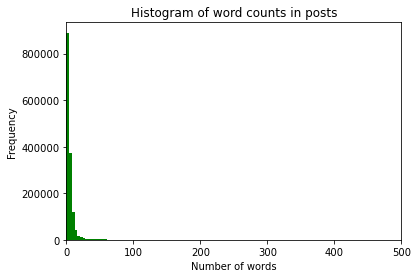

In [162]:
total.len.plot.hist(bins=1000, xlim=(0, 500), color='green')
plt.title('Histogram of word counts in posts')
plt.xlabel('Number of words')

### Preprocessing for Comments

In [109]:
train['cleanBody']=train['body'].map(lambda s:preprocess(s)) 

In [111]:
valid['cleanBody']=valid['body'].map(lambda s:preprocess(s)) 

In [113]:
test['cleanBody']=test['body'].map(lambda s:preprocess(s)) 

In [110]:
train.to_pickle('../../../Files/Comments/train/train_split_comments_s.pickle')

In [112]:

valid.to_pickle('../../../Files/Comments/train/val_split_comments_s.pickle')


In [114]:
test.to_pickle('../../../Files/Comments/train/test_split_comments_s.pickle')

In [143]:
total = train.append(test)

/var/folders/fh/yf9jwszj6d5_1_xhfz_l6k000000gn/T/ipykernel_26564/2212532589.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total = train.append(test)


In [146]:
total = total.append(valid)

/var/folders/fh/yf9jwszj6d5_1_xhfz_l6k000000gn/T/ipykernel_26564/781908578.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total = total.append(valid)


In [147]:
len(total)

256566

In [148]:
total['len'] = total['cleanBody'].apply(lambda x: len(x.split()))

Text(0.5, 0, 'Number of words')

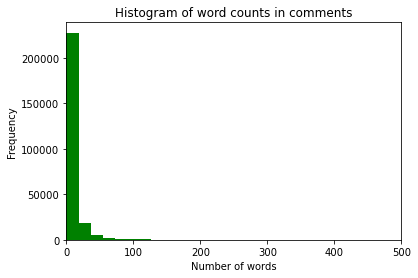

In [150]:

total.len.plot.hist(bins=100, xlim=(0, 500), color='green')
plt.title('Histogram of word counts in comments')
plt.xlabel('Number of words')

In [139]:
train = pd.read_pickle('../../../Files/Comments/train/train_split_comments_s.pickle')

## Preprocessing Posts for Scoring

In [5]:
files = os.listdir('../../../Files/Submissions/')

In [17]:
files = ['pics.pickle']

In [11]:
for file in files:
    if file[-7:] != ".pickle":
        files.pop(files.index(file))

In [18]:
from tqdm import tqdm

for file in tqdm(files):
    df = pd.read_pickle(os.path.join('../../../Files/Submissions/',file))
    df['cleanTitle']=df['title'].map(lambda s:preprocess(s)) 
    df.to_pickle(os.path.join('../../../Files/Submissions/',file))

100%|██████████| 1/1 [12:57<00:00, 777.01s/it]


In [43]:
files = os.listdir('../../../Files/Submissions/')

# remove any files that are not in the .pickle type 
files = [f for f in files if f.endswith('.pickle')]

In [44]:
len(files)

611

In [28]:
import csv
from itertools import chain
with open('../../Preprocessing/subreddits_sm.csv', newline='') as f:
    reader = csv.reader(f)
    subreddits = list(reader)

subreddits = list(chain.from_iterable(subreddits))

In [30]:
files[0][:-7]

'Qult_Headquarters'

In [67]:
for file in files:
    if file[:-7] not in subreddits:
        files.pop(files.index(file))


In [58]:
len(subreddits)

298

In [72]:
for file in files:
    #move file to the score directory
    os.rename(os.path.join('../../../Files/Submissions/',file), os.path.join('../../../Files/Submissions/score/',file))


In [71]:
files.index('AIandRobotics.pickle')

ValueError: 'AIandRobotics.pickle' is not in list